In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import pymc.sampling_jax
import aesara.tensor as aet
import arviz as az

/Users/tar15/opt/anaconda3/envs/mortality-pymc/lib/python3.10/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/tar15/opt/anaconda3/envs/mortality-pymc/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
pm.__version__

'4.0.0b6'

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/pyro-ppl/datasets/master/simulated_mortality.csv")
data.head()

,age_group,year,a,s1,s2,t,deaths,population
0,0,2002,0,9,0,0,0,16
1,1,2002,1,9,0,0,1,50
2,5,2002,2,9,0,0,0,33
3,10,2002,3,9,0,0,0,37
4,15,2002,4,9,0,0,0,52


In [4]:
a, s1, s2, t, deaths, population = data[["a", "s1", "s2", "t", "deaths", "population"]].to_numpy().T

In [5]:
def create_lookup(s1, s2):
    """
    Create a map between s1 indices and unique s2 indices
    """
    lookup = np.column_stack([s1, s2])
    lookup = np.unique(lookup, axis=0)
    lookup = lookup[lookup[:, 1].argsort()]
    return lookup[:, 0]
    
lookup = create_lookup(s1, s2)

In [6]:
COORDS = {
    "observation": data.index.values,
    "age": np.unique(data[["a"]]),
    "space1": np.unique(data[["s1"]]),
    "space2": np.unique(data[["s2"]]),
    "time": np.unique(data[["t"]]),
}

COORDS["age_minus_origin"] = COORDS["age"][1:]
COORDS["time_minus_origin"] = COORDS["time"][1:]
COORDS

{'observation': array([    0,     1,     2, ..., 38643, 38644, 38645]),
 'age': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 'space1': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 'space2': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112]),
 'time': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8

In [13]:
with pm.Model(coords=COORDS) as model:
    # hyperpriors
    alpha0 = pm.Normal("alpha0", sigma=10.0)
    beta0 = pm.Normal("beta0", sigma=10.0)
    sigma_alpha_s1 = pm.HalfNormal("sigma_alpha_s1", 1.0)
    sigma_alpha_s2 = pm.HalfNormal("sigma_alpha_s2", 1.0)
    sigma_alpha_age = pm.HalfNormal("sigma_alpha_age", 1.0)
    sigma_beta_age = pm.HalfNormal("sigma_beta_age", 1.0)
    sigma_pi = pm.HalfNormal("sigma_pi", 1.0)

    # space, s2 centred on s1
    alpha_s1 = pm.Normal("alpha_s1", sigma=sigma_alpha_s1, dims="space1")
    alpha_s2 = pm.Normal("alpha_s2", sigma=sigma_alpha_s2, dims="space2")
    alpha_s = pm.Deterministic("alpha_s", alpha_s1[lookup] + alpha_s2, dims="space2")

    # RW over age
    alpha_age_innovations = pm.Normal("alpha_age_innovations", sigma=1.0, dims="age_minus_origin")
    alpha_age_raw_rw = aet.cumsum(aet.concatenate([aet.zeros(shape=(1,)), alpha_age_innovations], axis=-1), axis=-1)
    alpha_age = pm.Deterministic("alpha_age", alpha0 + alpha_age_raw_rw * sigma_alpha_age, dims="age")

    beta_age_innovations = pm.Normal("beta_age_innovations", sigma=1.0, dims="age_minus_origin")
    beta_age_raw_rw = aet.cumsum(aet.concatenate([aet.zeros(shape=(1,)), beta_age_innovations], axis=-1), axis=-1)
    beta_age = pm.Deterministic("beta_age", beta0 + beta_age_raw_rw * sigma_beta_age, dims="age")
    beta_age_cum = pm.Deterministic(
        "beta_age_cum",
        aet.outer(beta_age, aet.arange(max(COORDS["time"] + 1))),
        dims=("age", "time")
    )

    # RW over time
    pi_init = aet.zeros(shape=(1,))
    pi_innovations = pm.Normal("pi_innovations", sigma=1.0, dims="time_minus_origin")
    pi_raw_rw = aet.cumsum(aet.concatenate([pi_init, pi_innovations], axis=-1), axis=-1)

    pi = pm.Deterministic("pi", pi_raw_rw * sigma_pi, dims="time")
    
    # axis: age=-3, space=-2, time=-1
    latent_rate = alpha_age[:, None, None] + beta_age_cum[:, None, :] + alpha_s[:, None] + pi

    mu_logit = latent_rate[a, s2, t]
    pm.Binomial("deaths", n=population, logit_p=mu_logit, observed=deaths, dims="observations")

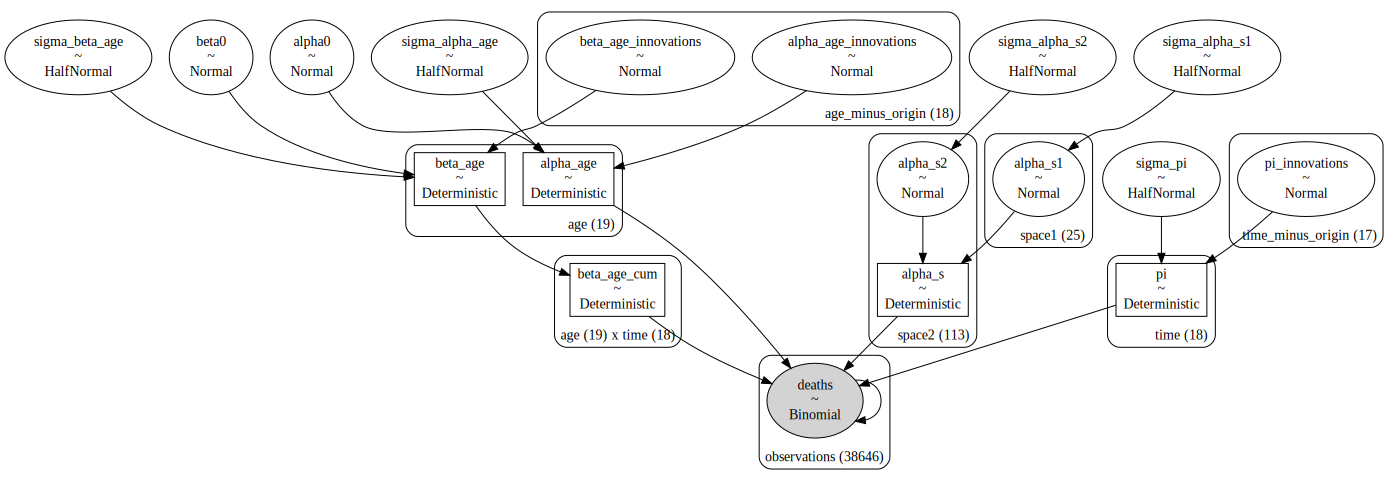

In [14]:
pm.model_to_graphviz(model)

In [15]:
with model:
    # idata = pm.sample(1000, tune=1000)
    idata = pm.sampling_jax.sample_numpyro_nuts(1000, tune=1000, chains=1)

Compiling...


/Users/tar15/opt/anaconda3/envs/mortality-pymc/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


Compilation time =  0:00:04.614302
Sampling...


sample: 100%|██████████| 2000/2000 [13:32<00:00,  2.46it/s, 63 steps of size 5.98e-02. acc. prob=0.94]   


Sampling time =  0:13:32.954167
Transforming variables...
Transformation time =  0:00:01.212300


In [16]:
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha0,-5.185,0.158,-5.475,-4.907,0.006,0.004,655.0,843.0,NaN
beta0,-0.017,0.022,-0.057,0.029,0.001,0.001,501.0,465.0,NaN
alpha_s1[0],0.199,0.168,-0.074,0.502,0.012,0.009,163.0,561.0,NaN
alpha_s1[1],-0.074,0.153,-0.365,0.221,0.006,0.008,580.0,357.0,NaN
alpha_s1[2],0.076,0.150,-0.215,0.346,0.006,0.006,625.0,822.0,NaN
...,...,...,...,...,...,...,...,...,...
pi[13],-0.022,0.259,-0.600,0.446,0.012,0.009,543.0,478.0,NaN
pi[14],-0.029,0.278,-0.717,0.432,0.013,0.009,546.0,468.0,NaN
pi[15],-0.012,0.294,-0.644,0.494,0.014,0.010,547.0,464.0,NaN
pi[16],-0.015,0.309,-0.711,0.509,0.015,0.011,535.0,495.0,NaN


/Users/tar15/opt/anaconda3/envs/mortality-pymc/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/tar15/opt/anaconda3/envs/mortality-pymc/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/tar15/opt/anaconda3/envs/mortality-pymc/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/tar15/opt/anaconda3/envs/mortality-pymc/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your da

array([[<AxesSubplot:title={'center':'alpha0'}>,
        <AxesSubplot:title={'center':'alpha0'}>],
       [<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'alpha_s1'}>,
        <AxesSubplot:title={'center':'alpha_s1'}>],
       [<AxesSubplot:title={'center':'alpha_s2'}>,
        <AxesSubplot:title={'center':'alpha_s2'}>],
       [<AxesSubplot:title={'center':'alpha_age_innovations'}>,
        <AxesSubplot:title={'center':'alpha_age_innovations'}>],
       [<AxesSubplot:title={'center':'beta_age_innovations'}>,
        <AxesSubplot:title={'center':'beta_age_innovations'}>],
       [<AxesSubplot:title={'center':'pi_innovations'}>,
        <AxesSubplot:title={'center':'pi_innovations'}>],
       [<AxesSubplot:title={'center':'sigma_alpha_s1'}>,
        <AxesSubplot:title={'center':'sigma_alpha_s1'}>],
       [<AxesSubplot:title={'center':'sigma_alpha_s2'}>,
        <AxesSubplot:title={'center':'sigma_alpha_s2'}>

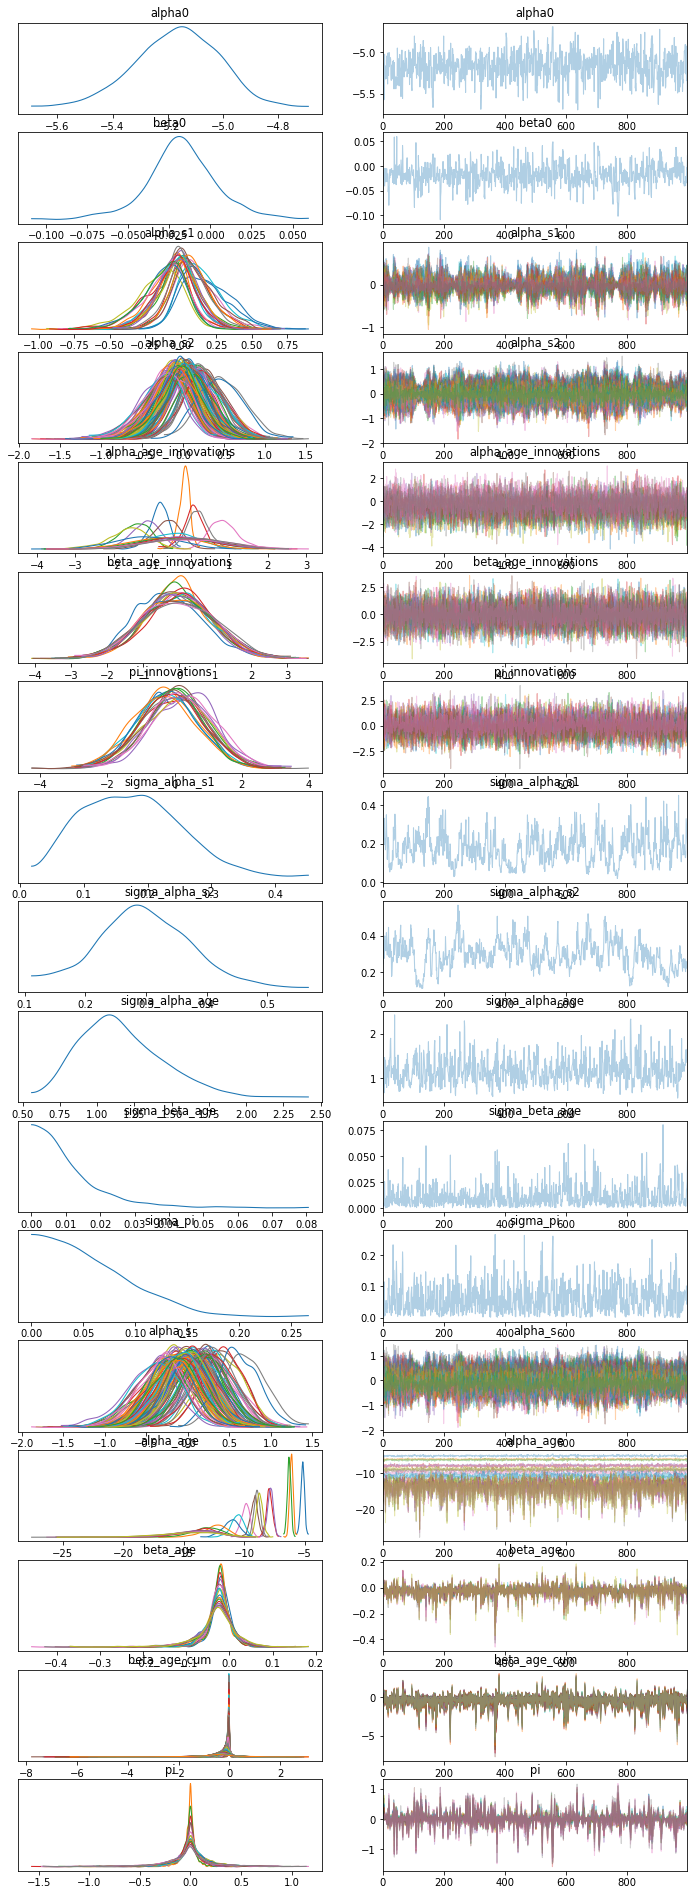

In [10]:
az.plot_trace(idata)